In [3]:
import os
import re
import json
import random
import math
import re
from collections import Counter
from statistics import median
import textwrap
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [5]:
# pretty print json
def pretty_print_json(data, max_width=80):
    json_str = json.dumps(data, indent=4)
    wrapped_lines = []
    for line in json_str.splitlines():
        wrapped_lines.extend(textwrap.wrap(line, width=max_width))
    return "\n".join(wrapped_lines)

file_path = os.path.join("eval_baseline_emrqa", "eval_predictions.jsonl")
with open(file_path, "r") as file:
    predictions = [json.loads(line) for line in file]

passed_examples = [
    prediction for prediction in predictions
    if prediction['predicted_answer'] == prediction['answers']['text'][0] # for whatever reason this is a list
]

# failed examples
failed_examples = [
    prediction for prediction in predictions
    if prediction['predicted_answer'] != prediction['answers']['text'][0] # for whatever reason this is a list
]

# Put Failed examples in a dataframe
failed = pd.DataFrame(failed_examples)
failed['answer'] = [v['text'][0] for v in failed["answers"].values]
# pd.set_option('display.max_colwidth', 20)
failed.columns
len(failed)

3248

In [ ]:
############################
# Basic text utilities
############################

STOPWORDS = {
    "the", "a", "an", "of", "to", "and", "or", "in", "on", "for",
    "with", "is", "are", "was", "were", "be", "been", "being",
    "at", "by", "from", "as", "that", "this", "these", "those",
    "it", "its", "he", "she", "they", "them", "his", "her", "their",
    "we", "you", "i", "but", "if", "then", "so", "because", "when",
    "while", "about", "into", "out", "up", "down", "over", "under"
}

WORD_RE = re.compile(r"\w+")
DATE_RE = re.compile(
    r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|"
    r"may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:t(?:ember)?)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\b",
    re.IGNORECASE,
)
NUMBER_RE = re.compile(r"\b\d+(?:\.\d+)?\b")

def normalize(text: str) -> str:
    return " ".join(text.lower().split())

def tokenize(text: str):
    return WORD_RE.findall(normalize(text))

def jaccard_similarity(a_tokens, b_tokens):
    a_set, b_set = set(a_tokens), set(b_tokens)
    if not a_set or not b_set:
        return 0.0
    inter = len(a_set & b_set)
    union = len(a_set | b_set)
    return inter / union

# to identify repetitive/uninformative answers
def shannon_entropy(tokens):
    if not tokens:
        return 0.0
    counts = Counter(tokens)
    total = sum(counts.values())
    ent = 0.0
    for c in counts.values():
        p = c / total
        ent -= p * math.log2(p)
    return ent

def count_dates(text: str) -> int:
    return len(DATE_RE.findall(text))

def count_numbers(text: str) -> int:
    return len(NUMBER_RE.findall(text))

def stopword_ratio(tokens):
    if not tokens:
        return 1.0
    sw = sum(1 for t in tokens if t in STOPWORDS)
    return sw / len(tokens)


############################
# Dataset-level stats
############################

def compute_dataset_stats(examples):
    """
    Compute basic stats over gold spans & question-span similarity
    so rules can use dynamic thresholds.
    """
    gold_lengths = []
    qg_sims = []

    for ex in examples:
        gold = ex["answers"]["text"][0]
        question = ex["question"]
        gold_tokens = tokenize(gold)
        q_tokens = tokenize(question)

        if not gold_tokens:
            continue

        gold_lengths.append(len(gold_tokens))
        qg_sims.append(jaccard_similarity(q_tokens, gold_tokens))

    if not gold_lengths:
        # degenerate case
        return {
            "median_gold_len": 0,
            "mad_gold_len": 0,
            "p95_gold_len": 0,
            "mean_qg_sim": 0.0,
            "std_qg_sim": 0.0,
        }

    # median and MAD
    med_len = median(gold_lengths)
    abs_dev = [abs(l - med_len) for l in gold_lengths]
    mad_len = median(abs_dev)

    # rough p95
    sorted_lens = sorted(gold_lengths)
    idx_95 = int(0.95 * (len(sorted_lens) - 1))
    p95_len = sorted_lens[idx_95]

    # mean and std of q–gold similarity
    if qg_sims:
        mean_sim = sum(qg_sims) / len(qg_sims)
        var_sim = sum((s - mean_sim) ** 2 for s in qg_sims) / max(len(qg_sims) - 1, 1)
        std_sim = math.sqrt(var_sim)
    else:
        mean_sim, std_sim = 0.0, 0.0

    return {
        "median_gold_len": med_len,
        "mad_gold_len": mad_len,
        "p95_gold_len": p95_len,
        "mean_qg_sim": mean_sim,
        "std_qg_sim": std_sim,
    }


############################
# Rule implementations
############################

# Extremely long answers may indicate annotation errors where too much text was selected
def rule1_length_anomaly(gold_tokens, stats):
    L = len(gold_tokens)
    med = stats["median_gold_len"]
    mad = stats["mad_gold_len"]
    p95 = stats["p95_gold_len"]

    too_long_vs_p95 = L > p95
    too_long_vs_mad = mad > 0 and L > med + 2 * mad
    return too_long_vs_p95 or too_long_vs_mad

def split_clauses(text: str):
    # very rough clause segmentation
    clauses = re.split(r'[,\n;]| and | or ', text)
    # keep clauses that have at least 2 non-stopword tokens
    clean_clauses = []
    for c in clauses:
        toks = tokenize(c)
        non_sw = [t for t in toks if t not in STOPWORDS]
        if len(non_sw) >= 2:
            clean_clauses.append(c.strip())
    return clean_clauses

# Multi-clause answers may be over segmented or contain irrelevant information
def rule2_multi_clause(gold_text: str):
    clauses = split_clauses(gold_text)
    return len(clauses) > 1


# def rule3_low_question_similarity(question_tokens, gold_tokens, stats, k=1.0):
#     sim = jaccard_similarity(question_tokens, gold_tokens)
#     mean_sim = stats["mean_qg_sim"]
#     std_sim = stats["std_qg_sim"]
#     # flag if sim is much lower than typical q–gold sim
#     threshold = mean_sim - k * std_sim
#     # if std_sim == 0, threshold == mean_sim; low sim will be 0, so flagged
#     return sim < threshold

# Most commonly observed issue: The Model extracts a more relevant portion of an over-annotated gold answer
def rule4_pred_inside_gold_and_better_align(pred_text, gold_text, question_tokens):
    gold_norm = normalize(gold_text)
    pred_norm = normalize(pred_text)
    # substring check in normalized space
    if pred_norm and pred_norm in gold_norm:
        gold_tokens = tokenize(gold_text)
        pred_tokens = tokenize(pred_text)
        sim_gold = jaccard_similarity(question_tokens, gold_tokens)
        sim_pred = jaccard_similarity(question_tokens, pred_tokens)
        return sim_pred > sim_gold + 0.1  # margin; tune if needed
    return False

def classify_question_type(question: str):
    q = question.lower()
    if any(x in q for x in ["when", "date", "time", "year", "day", "month"]):
        return "time"
    if "how many" in q or "number of" in q or "count" in q:
        return "number"
    # you can expand this as needed (medication, lab, diagnosis, etc.)
    return "other"

def rule5_question_type_mismatch(gold_text: str, question: str):
    q_type = classify_question_type(question)
    if q_type == "time":
        n_dates = count_dates(gold_text)
        return n_dates != 1  # we expect exactly one
    if q_type == "number":
        n_nums = count_numbers(gold_text)
        return n_nums != 1
    return False  # for "other" we don't use this rule

def rule6_multiple_occurrences(gold_text: str, context: str):
    gold_norm = normalize(gold_text)
    ctx_norm = normalize(context)
    if not gold_norm:
        return False
    return ctx_norm.count(gold_norm) > 1

# lot of answers only have '.' or ',' so it must be predicting wrong span.
def rule7_boundary_weirdness(gold_text: str):
    stripped = gold_text.strip()
    if not stripped:
        return False
    starts_bad = stripped[0] in {",", ";", ":", "-", "."}
    ends_bad = stripped[-1] in {",", ";", ":", "-", "(", "/"}
    return starts_bad or ends_bad

def rule8_low_entropy(gold_tokens):
    ent = shannon_entropy(gold_tokens)
    # heuristic: very low entropy for longer spans is suspicious
    return len(gold_tokens) >= 5 and ent < 1.0

# def rule9_high_stopword_ratio(gold_tokens, threshold=0.7):
#     return stopword_ratio(gold_tokens) > threshold

# # prediction better than answers
# def rule10_pred_better_answers_question(pred_text, gold_text, question_tokens):
#     gold_tokens = tokenize(gold_text)
#     pred_tokens = tokenize(pred_text)
#     sim_gold = jaccard_similarity(question_tokens, gold_tokens)
#     sim_pred = jaccard_similarity(question_tokens, pred_tokens)
#     return sim_pred > sim_gold + 0.1  # margin


############################
# Overall dataset-error detector
############################

def detect_dataset_error(example, stats, min_rules_triggered=2):
    """
    Returns (is_dataset_error, details_dict)
    details_dict tells you which rules fired.
    """
    context = example["context"]
    question = example["question"]
    gold_text = example["answers"]["text"][0]
    pred_text = example.get("predicted_answer", "")

    gold_tokens = tokenize(gold_text)
    question_tokens = tokenize(question)

    # individual rule flags
    flags = {}

    flags["rule1_length_anomaly"] = rule1_length_anomaly(gold_tokens, stats)
    flags["rule2_multi_clause"] = rule2_multi_clause(gold_text)
    #flags["rule3_low_q_sim"] = rule3_low_question_similarity(question_tokens, gold_tokens, stats)
    flags["rule4_pred_inside_gold_better_align"] = rule4_pred_inside_gold_and_better_align(
        pred_text, gold_text, question_tokens
    )
    flags["rule5_qtype_mismatch"] = rule5_question_type_mismatch(gold_text, question)
    flags["rule6_multi_occurrences"] = rule6_multiple_occurrences(gold_text, context)
    flags["rule7_boundary_weirdness"] = rule7_boundary_weirdness(gold_text)
    flags["rule8_low_entropy"] = rule8_low_entropy(gold_tokens)
    # flags["rule9_high_stopword_ratio"] = rule9_high_stopword_ratio(gold_tokens)
    # flags["rule10_pred_better_answer"] = rule10_pred_better_answers_question(pred_text, gold_text, question_tokens)

    num_true = sum(flags.values())
    is_error = num_true >= min_rules_triggered

    return is_error, flags


stats = compute_dataset_stats(predictions)

IndentationError: expected an indented block after function definition on line 217 (3037764688.py, line 233)

In [7]:

results = []
for ex in predictions:
    is_err, flags = detect_dataset_error(ex, stats, min_rules_triggered=2)
    results.append({
        "id": ex["id"],
        "is_dataset_error": is_err,
        "flags": flags,
        "gold": ex["answers"]["text"][0],
        "pred": ex.get("predicted_answer", ""),
        "question": ex["question"],
    })

import pandas as pd

df = pd.DataFrame(results)

total = len(df)
num_ds_errors = df["is_dataset_error"].sum()

print("Total examples:", total)
print("Dataset errors:", num_ds_errors)
print("Percentage:", num_ds_errors / total * 100, "%")

def is_failure(row):
    return row["pred"] != row["gold"]

df["is_failure"] = df.apply(is_failure, axis=1)

failed_df = df[df["is_failure"] == True]

fail_total = len(failed_df)
fail_ds_errors = failed_df["is_dataset_error"].sum()

print("Model failures:", fail_total)
print("Dataset errors among failures:", fail_ds_errors)
print("Percentage:", fail_ds_errors / fail_total * 100, "%")
rule_columns = list(results[0]["flags"].keys())

rule_counts = {rule: 0 for rule in rule_columns}

for r in results:
    for rule, val in r["flags"].items():
        if val:
            rule_counts[rule] += 1

print("=== Rule Trigger Rates ===")
for rule, count in rule_counts.items():
    print(f"{rule}: {count} ({count/total*100:.2f}%)")


Total examples: 32739
Dataset errors: 11249
Percentage: 34.35963224289074 %
Model failures: 3248
Dataset errors among failures: 2829
Percentage: 87.09975369458128 %
=== Rule Trigger Rates ===
rule1_length_anomaly: 4176 (12.76%)
rule2_multi_clause: 10250 (31.31%)
rule3_low_q_sim: 3002 (9.17%)
rule4_pred_inside_gold_better_align: 19 (0.06%)
rule5_qtype_mismatch: 722 (2.21%)
rule6_multi_occurrences: 1871 (5.71%)
rule7_boundary_weirdness: 21825 (66.66%)
rule8_low_entropy: 0 (0.00%)
rule9_high_stopword_ratio: 0 (0.00%)
rule10_pred_better_answer: 57 (0.17%)


In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
failed[failed['question'].str.lower().str.startswith('has')].head(50)
gemfibrozil_examples = failed[failed['question'].str.lower().str.contains('gemfibrozil')]
len(gemfibrozil_examples)

10

In [7]:
len(failed[failed['predicted_answer'] == ',']), len(failed[failed['predicted_answer'] == '.'])

(684, 182)

In [16]:
nitroglycerin_examples = failed[failed['question'].str.lower().str.contains('nitroglycerin')]
len(nitroglycerin_examples)

152

###  Baseline EMRQA prediction error analysis
- High-level error patterns for `eval_baseline_emrqa/eval_predictions.jsonl`
- Label wrong predictions as `truncated_span`, `overlong_span`, `partial_overlap`, or `no_overlap` and show counts/examples.

In [6]:
# Helpers
token_re = re.compile(r"\w+")
relation = ["truncated_span", "overlong_span", "partial_overlap", "no_overlap"]

def norm(text):
    return " ".join(text.lower().split())

def tokens(text: str):
    return token_re.findall(text.lower())

def span_relation(prediction: str, actual: str):
    p = norm(prediction)
    a = norm(actual)
    if p and p in a:
        return relation[0]
    if a and a in p:
        return relation[1]
    if set(tokens(p)) & set(tokens(a)):
        return relation[2]
    return relation[3]

# Add a new column to the failed dataframe for the span relation
failed['relation'] = failed.apply(
    lambda row: span_relation(
        row.get("predicted_answer", "") or "",
        row.get("answer", "") or ""
    ),
    axis=1
)

# Display counts from the failed dataframe
print(f"Total wrong predictions: {len(failed)}")
print("Wrong predictions by type:")
print(failed["relation"].value_counts())

# Use the following filter to deep dive
# failed[failed["relation"] == relation[0]][["id", "question", "predicted_answer", "answer"]].head(5)

Total wrong predictions: 3248
Wrong predictions by type:
relation
truncated_span     2714
overlong_span       272
partial_overlap     193
no_overlap           69
Name: count, dtype: int64


### Deep Dive into Baseline EMRQA Prediction Errors

In [11]:
failed['gold_norm'] = failed['answer'].apply(norm)
failed['pred_norm'] = failed['predicted_answer'].apply(norm)
failed["clust_text"] = failed.apply(
    lambda r: f"Q: {r['question']} GOLD: {r['gold_norm']} PRED: {r['pred_norm']}",
    axis=1
)

Tfidf + k-means did not yield meaningful clusters here.

In [42]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=5
)

X = vectorizer.fit_transform(failed["clust_text"])
X.shape

(3248, 3000)

In [43]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=100)
cluster_labels = kmeans.fit_predict(X)

failed["cluster"] = cluster_labels
cluster_sizes = failed["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0      81
1     217
2     448
3     249
4    1328
5     193
6     228
7     156
8      76
9     272
Name: count, dtype: int64

Per Cluster Analysis

In [46]:
cluster_summaries = {}

for c in sorted(failed["cluster"].unique()):
    sub = failed[failed["cluster"] == c]

    qs = sub["question"].astype(str).tolist()
    if len(qs) < 5:
        continue

    cv = CountVectorizer(
        max_features=2000,
        ngram_range=(1,3),
        stop_words="english"
    )
    Xq = cv.fit_transform(qs)

    sums = np.asarray(Xq.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:15]

    cluster_summaries[c] = {
        "n": len(sub),
        "top_terms": list(terms[top_idx]),
        "error_dist": sub["relation"].value_counts().to_dict()
    }

cluster_summaries

{np.int32(0): {'n': 81,
  'top_terms': ['patient',
   'darvocet',
   '100',
   'darvocet 100',
   'pain',
   'roxicet',
   'acetaminophen',
   'darvocet 100 propoxyphene',
   '100 propoxyphene nap',
   'nap',
   'propoxyphene nap acetaminophen',
   'nap acetaminophen',
   'propoxyphene',
   'propoxyphene nap',
   '100 propoxyphene'],
  'error_dist': {'truncated_span': 63, 'overlong_span': 18}},
 np.int32(1): {'n': 217,
  'top_terms': ['patient',
   'lopressor',
   'prescribed',
   'nitroglycerin',
   'patient prescribed',
   'isordil',
   'tried',
   'patient tried',
   'current dose',
   'dose',
   'current',
   'pain',
   'past',
   'does',
   'does patient'],
  'error_dist': {'truncated_span': 207,
   'partial_overlap': 6,
   'no_overlap': 4}},
 np.int32(2): {'n': 448,
  'top_terms': ['patient',
   'does patient',
   'does',
   'current dose',
   'current',
   'dose',
   'insulin',
   'lasix',
   'prescribed',
   'colace',
   'nph',
   'patient prescribed',
   'patient tried',
   't

In [47]:
for c in sorted(cluster_summaries.keys()):
    info = cluster_summaries[c]
    print("="*70)
    print(f"Cluster {c}  |  n = {info['n']}")
    print("Top terms:", ", ".join(info["top_terms"]))
    print("Error types:", info["error_dist"])
    print()

Cluster 0  |  n = 81
Top terms: patient, darvocet, 100, darvocet 100, pain, roxicet, acetaminophen, darvocet 100 propoxyphene, 100 propoxyphene nap, nap, propoxyphene nap acetaminophen, nap acetaminophen, propoxyphene, propoxyphene nap, 100 propoxyphene
Error types: {'truncated_span': 63, 'overlong_span': 18}

Cluster 1  |  n = 217
Top terms: patient, lopressor, prescribed, nitroglycerin, patient prescribed, isordil, tried, patient tried, current dose, dose, current, pain, past, does, does patient
Error types: {'truncated_span': 207, 'partial_overlap': 6, 'no_overlap': 4}

Cluster 2  |  n = 448
Top terms: patient, does patient, does, current dose, current, dose, insulin, lasix, prescribed, colace, nph, patient prescribed, patient tried, tried, previous
Error types: {'truncated_span': 389, 'partial_overlap': 35, 'overlong_span': 19, 'no_overlap': 5}

Cluster 3  |  n = 249
Top terms: patient, prescribed, current, current dose, dose, patient prescribed, does, does patient, xl, meds, prior

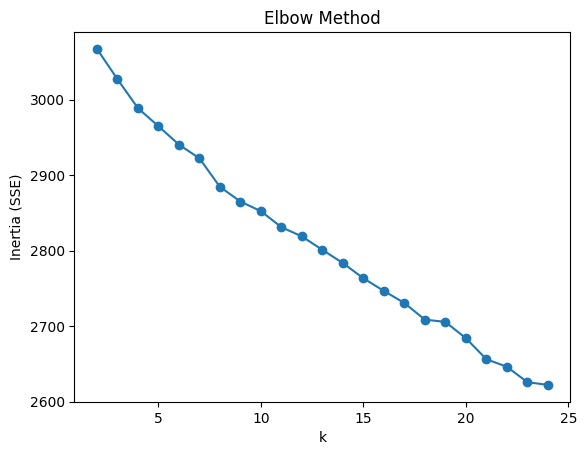

In [49]:
ks = list(range(2, 25))
sse = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=10, max_iter=200)
    km.fit(X)
    sse.append(km.inertia_)

plt.plot(ks, sse, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

Cluster error types in failed examples for further analysis. This uses sentence transformers to embed the question, context, and predicted/true answers, then clusters them using KMeans. This seems to work better.

In [ ]:
model = SentenceTransformer("sentence-transformers/embeddinggemma-300m-medical")

embed_texts = failed["clust_text"].tolist()
embeddings = model.encode(
    embed_texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

embeddings.shape


You are trying to use a model that was created with Sentence Transformers version 5.2.0.dev0, but you're currently using version 5.1.2. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


Batches: 100%|██████████| 51/51 [00:04<00:00, 12.20it/s]


(3248, 768)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(embeddings)

failed["pca_x"] = pca_2d[:, 0]
failed["pca_y"] = pca_2d[:, 1]

k= 2  silhouette=0.0968
k= 3  silhouette=0.0518
k= 4  silhouette=0.0546
k= 5  silhouette=0.0584
k= 6  silhouette=0.0648
k= 7  silhouette=0.0551
k= 8  silhouette=0.0669
k= 9  silhouette=0.0639
k=10  silhouette=0.0730
k=11  silhouette=0.0691
k=12  silhouette=0.0708
k=13  silhouette=0.0772
k=14  silhouette=0.0662
k=15  silhouette=0.0765


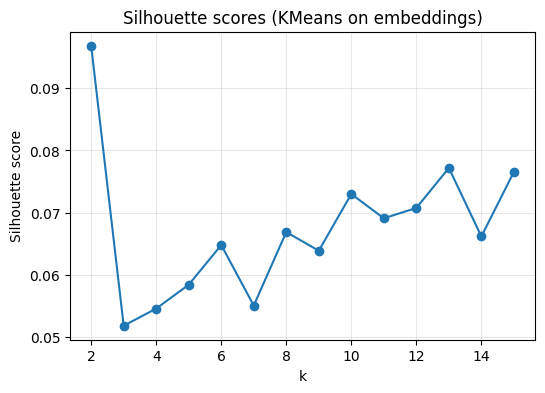

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from spherecluster import SphericalKMeans

embeddings = normalize(embeddings)
ks = list(range(2, 16))
sil_scores = []

for k in ks:
    km = KMeans(
        n_clusters=k,
        random_state=0,
        n_init=10,
        max_iter=300
    )
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    sil_scores.append(score)
    print(f"k={k:2d}  silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores (KMeans on embeddings)")
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
from sklearn.cluster import KMeans

best_k = 13

kmeans = KMeans(
    n_clusters=best_k,
    random_state=0,
    n_init=10,
    max_iter=300
)
k_labels = kmeans.fit_predict(embeddings)

failed["cluster_kmeans"] = k_labels
failed["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0     104
1     543
2     409
3     195
4     389
5     235
6     523
7      69
8     136
9     111
10    124
11    232
12    178
Name: count, dtype: int64

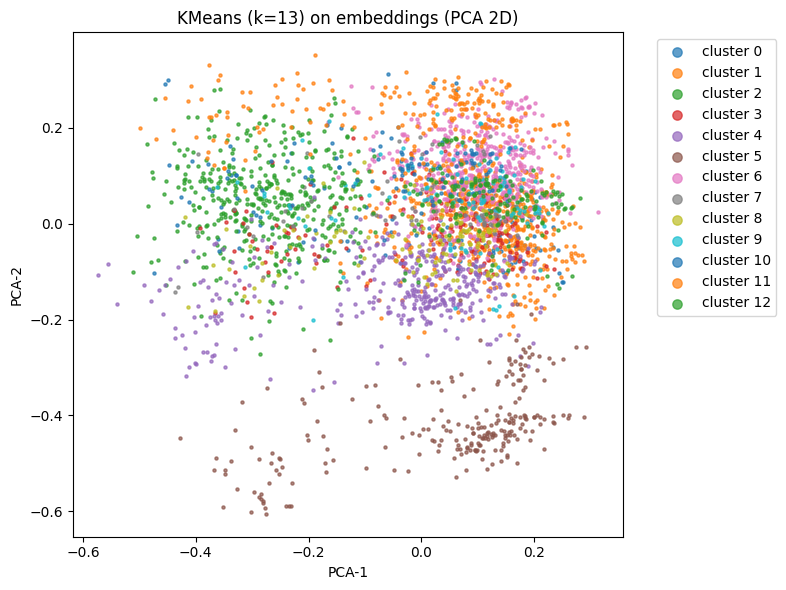

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cid in sorted(failed["cluster_kmeans"].unique()):
    mask = failed["cluster_kmeans"] == cid
    plt.scatter(
        failed.loc[mask, "pca_x"],
        failed.loc[mask, "pca_y"],
        s=5,
        alpha=0.7,
        label=f"cluster {cid}"
    )

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title(f"KMeans (k={best_k}) on embeddings (PCA 2D)")
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cluster_k_info = {}

for cid in sorted(failed["cluster_kmeans"].unique()):
    sub = failed[failed["cluster_kmeans"] == cid]
    n = len(sub)
    rel_dist = sub["relation"].value_counts().to_dict()
    
    top_terms = []
    if n >= 5:
        cv = CountVectorizer(
            max_features=2000,
            ngram_range=(1,2),
            stop_words="english"
        )
        Xq = cv.fit_transform(sub["question"].astype(str).tolist())
        sums = np.asarray(Xq.sum(axis=0)).ravel()
        terms = np.array(cv.get_feature_names_out())
        top_idx = sums.argsort()[::-1][:15]
        top_terms = list(terms[top_idx])
    
    cluster_k_info[cid] = {
        "n": n,
        "relation_dist": rel_dist,
        "top_terms": top_terms,
    }

for cid, info in cluster_k_info.items():
    print("="*80)
    print(f"Cluster {cid}  |  n = {info['n']}")
    print("Error-type distribution:", info["relation_dist"])
    print("Top question terms:", ", ".join(info["top_terms"]))
    print()

Cluster 0  |  n = 104
Error-type distribution: {'truncated_span': 93, 'overlong_span': 5, 'partial_overlap': 4, 'no_overlap': 2}
Top question terms: aspirin, patient, patient aspirin, current, dose, does, current dose, does patient, prescribed, enteric coated, coated, coated aspirin, enteric, patient prescribed, lantus

Cluster 1  |  n = 543
Error-type distribution: {'truncated_span': 449, 'partial_overlap': 38, 'overlong_span': 38, 'no_overlap': 18}
Top question terms: patient, prescribed, patient prescribed, past, tried, does, patient tried, does patient, lopressor, dose, current, current dose, xl, medications, used

Cluster 2  |  n = 409
Error-type distribution: {'truncated_span': 331, 'overlong_span': 46, 'partial_overlap': 17, 'no_overlap': 15}
Top question terms: dosage, record, prior, current dose, dose, current, usage prescription, prescription record, mention, usage, prescription, prescribed, previous, dosage prescribed, history

Cluster 3  |  n = 195
Error-type distribution: 

### Manual Review of Sampled Errors

- No. of questions in the train dataset that start with "has" is 62872/130,956
- No. of questions in the validation dataset that start with "has" is 15913/32739
- No. of questions in the failed examples that start with "has" is 1423/3248

This examines the whole dataset for train and eval to see how many questions start with "has", 'why' etc.

In [ ]:
from datasets import load_dataset
train = load_dataset("Eladio/emrqa-msquad", split="train")

# Filter questions that start with "why"
why_questions = train.filter(lambda example: example["question"].lower().startswith("why"))

why_questions_df = pd.DataFrame(why_questions)
len(why_questions_df)

In [ ]:
from datasets import load_dataset
eval = load_dataset("Eladio/emrqa-msquad", split="validation")

# Filter questions that start with "has"
has_questions = eval.filter(lambda example: example["question"].lower().startswith("has"))

# Display the filtered examples
has_questions_df = pd.DataFrame(has_questions)
has_questions_df['question']

Insulin

In [61]:
insulin_questions = failed[failed['question'].str.contains('insulin', case=False, na=False)]
len(insulin_questions)

97

Chest pain

In [62]:
chest_pain_questions = failed[failed['question'].str.contains('chest pain', case=False, na=False)]
len(chest_pain_questions)

72

Medication

In [63]:
medication_questions = failed[failed['question'].str.contains('medication', case=False, na=False)]
len(chest_pain_questions)

72

Clusters by Drug Type.
"Nitroglycerin" is a medication for chest pain. It seems that model struggles with medications for certain conditions, for example, medications for chest pain.

In [19]:
failed["drug"] = failed["gold_norm"].str.extract(r"([a-z]+)")
failed.groupby("drug")["relation"].value_counts().sort_values(ascending=False)

drug           relation       
nitroglycerin  truncated_span     90
toprol         truncated_span     80
percocet       truncated_span     79
lopressor      truncated_span     75
zocor          truncated_span     73
                                  ..
take           partial_overlap     1
to             partial_overlap     1
three          overlong_span       1
zocor          partial_overlap     1
acetaminophen  partial_overlap     1
Name: count, Length: 356, dtype: int64